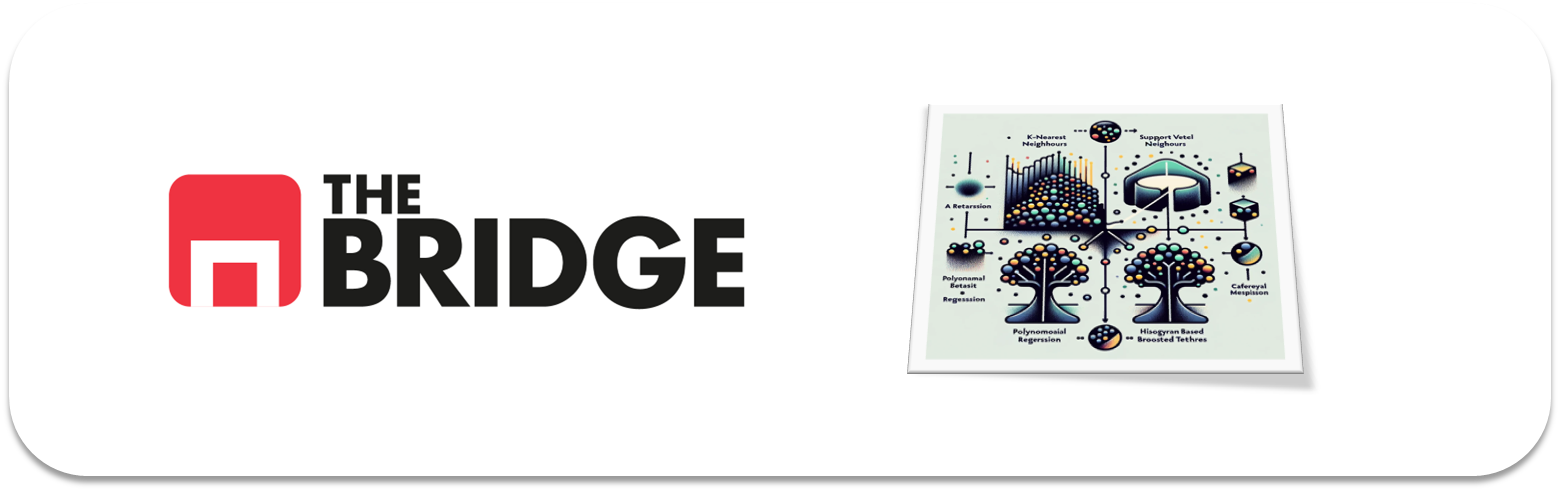

* La práctica consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [69]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [70]:
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error #Regresion
from sklearn.metrics import balanced_accuracy_score #clasificacion
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, \
roc_curve, roc_auc_score, ConfusionMatrixDisplay, multilabel_confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

NOTA: El dataset está limpio y sin valores faltantes.

In [71]:
df = pd.read_csv("datasets\\wines_dataset.csv", sep="|")

## Previo

### EDA

In [72]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,0.21,0.26,9.25,0.034,73.0,142.0,0.99450,3.05,0.37,11.4,6,white
1,8.3,0.16,0.37,7.90,0.025,38.0,107.0,0.99306,2.93,0.37,11.9,6,white
2,6.8,0.18,0.38,1.40,0.038,35.0,111.0,0.99180,3.32,0.59,11.2,7,white
3,6.1,0.26,0.25,2.90,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3,white
4,7.5,0.63,0.27,2.00,0.083,17.0,91.0,0.99616,3.26,0.58,9.8,6,red


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [74]:
df.shape

(6497, 13)

In [75]:
df["quality"].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [76]:
df["class"].value_counts()

class
white    4898
red      1599
Name: count, dtype: int64

In [77]:
df.groupby("class")["quality"].agg(pd.Series.mode)

class
red      5
white    6
Name: quality, dtype: int64

In [78]:
#sns.pairplot(df)

<Axes: xlabel='class', ylabel='count'>

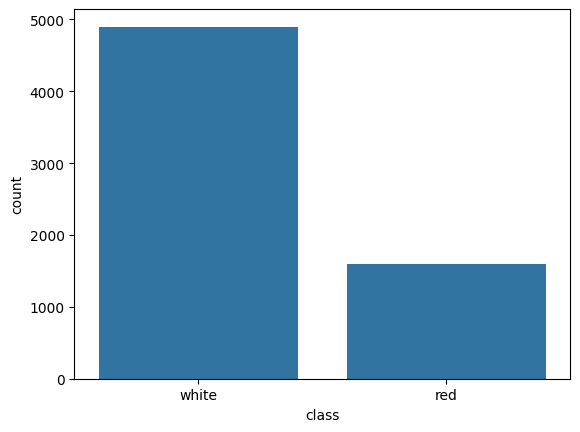

In [79]:
sns.countplot(df, x="class")

<Axes: xlabel='quality', ylabel='Count'>

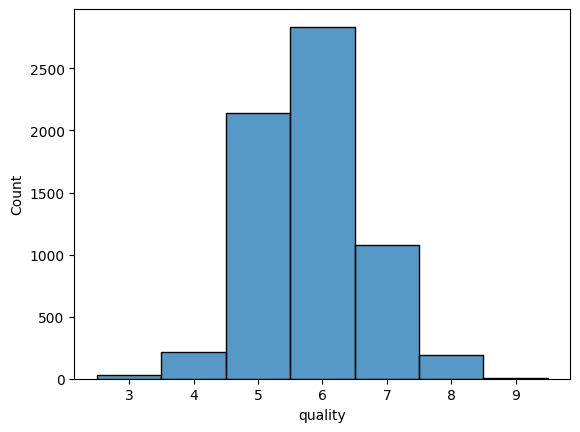

In [80]:
sns.histplot(df, x="quality", discrete=True)

<Axes: xlabel='class', ylabel='count'>

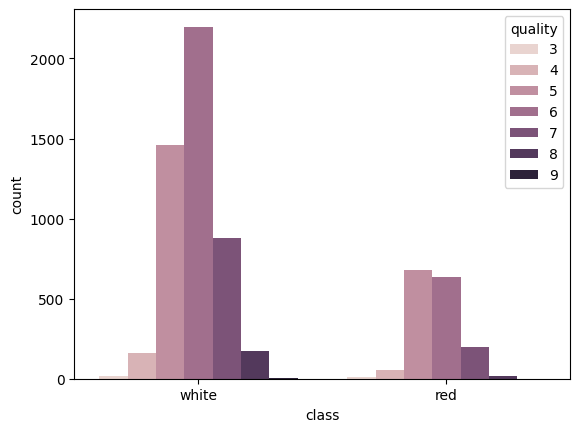

In [81]:
sns.countplot(df, x="class", hue="quality")

In [82]:
def cardinalidad(df):

    columnas = df.columns

    unicos = df.nunique()

    card_100 = [(df[i].nunique()/len(df))*100 for i in df]

    tipo_dato = []
    
    for x in df.columns:
        if df[x].dtypes == '<M8[ns]':
            y = "datetime"
            tipo_dato.append(y)
        elif df[x].nunique() == 2:
            y = "boolean"
            tipo_dato.append(y)
        elif df[x].nunique() != 2 and df[x].dtype == "O":
            y = "categorical"
            tipo_dato.append(y)
        elif df[x].nunique() != 2 and df[x].dtype == "float64":
            y = "numerical"
            tipo_dato.append(y)
        elif df[x].nunique() != 2 and df[x].dtype == "int64":
            y = "numerical"
            tipo_dato.append(y)
        

    cardinality = pd.DataFrame({"Columna":columnas, "Total de únicos":unicos, 
                                "Cardinalidad (%)":card_100, "Tipo de dato": tipo_dato}).set_index("Columna")
    
    return cardinality

In [83]:
cardinalidad(df)

,Total de únicos,Cardinalidad (%),Tipo de dato
Columna,,,
fixed acidity,106,1.631522,numerical
volatile acidity,187,2.878252,numerical
citric acid,89,1.369863,numerical
residual sugar,316,4.863783,numerical
chlorides,214,3.293828,numerical
free sulfur dioxide,135,2.077882,numerical
total sulfur dioxide,276,4.248115,numerical
density,998,15.360936,numerical
pH,108,1.662306,numerical


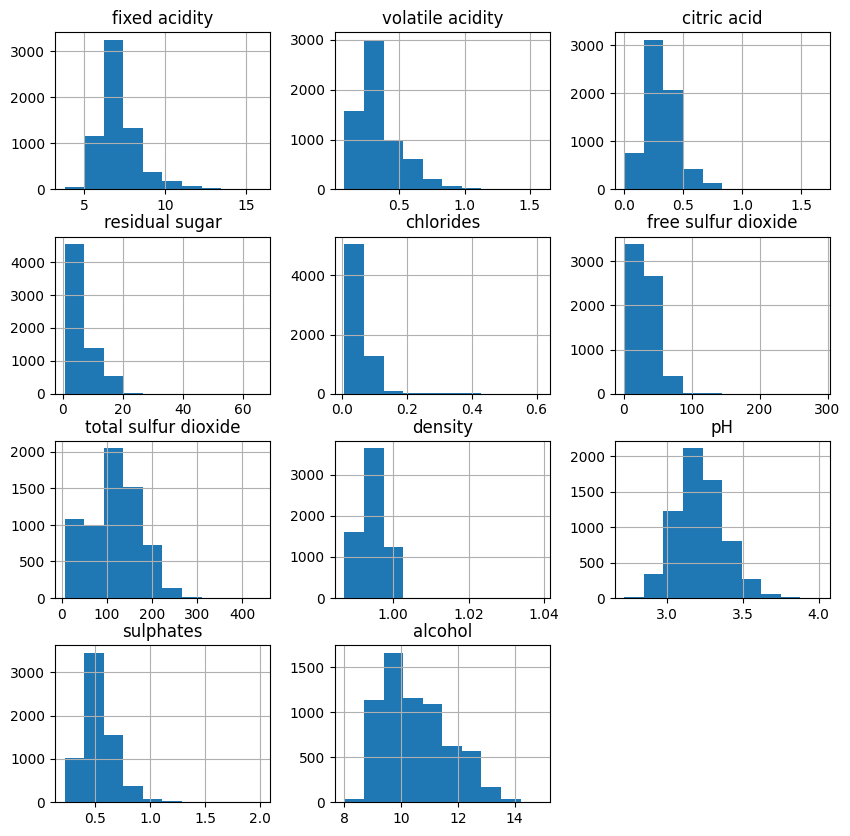

In [84]:
df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']].hist(figsize=(10,10));

In [85]:
df_map = df.copy()
df_map["class"] = df_map["class"].replace(["white", "red"], [0,1])

<Axes: >

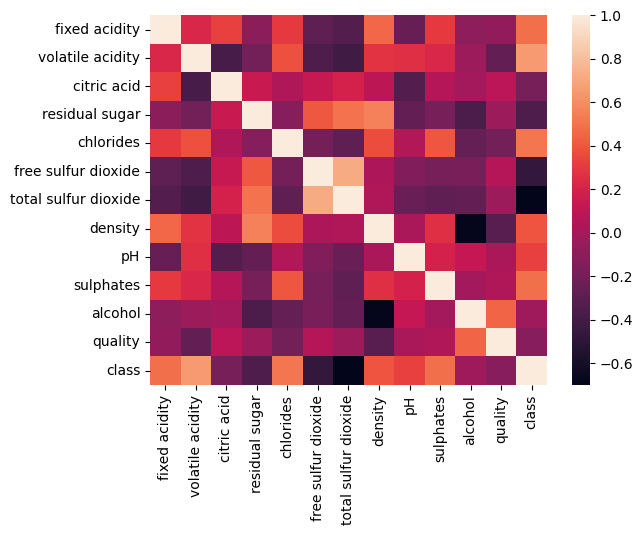

In [86]:
sns.heatmap(df_map.corr(), )

In [87]:
X_class = df_map.drop(columns="class")
X_reg = df_map.drop(columns="alcohol")
y_class = df["class"]
y_reg = df["alcohol"]

In [88]:
df_log = df_map.copy()
df_log[["volatile acidity", "residual sugar", "chlorides",
     "free sulfur dioxide"]] = np.log(df[["volatile acidity", "residual sugar", "chlorides", "free sulfur dioxide"]])
df_log

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,8.5,-1.560648,0.26,2.224624,-3.381395,4.290459,142.0,0.99450,3.05,0.37,11.4,6,0
1,8.3,-1.832581,0.37,2.066863,-3.688879,3.637586,107.0,0.99306,2.93,0.37,11.9,6,0
2,6.8,-1.714798,0.38,0.336472,-3.270169,3.555348,111.0,0.99180,3.32,0.59,11.2,7,0
3,6.1,-1.347074,0.25,1.064711,-3.057608,5.666427,440.0,0.99314,3.44,0.64,10.5,3,0
4,7.5,-0.462035,0.27,0.693147,-2.488915,2.833213,91.0,0.99616,3.26,0.58,9.8,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,7.7,-0.941609,0.34,2.302585,-2.882404,3.555348,178.0,0.99740,3.26,0.60,10.2,5,0
6493,8.2,-0.314711,0.21,0.530628,-2.603690,1.609438,13.0,0.99680,3.20,0.52,9.5,5,1
6494,7.4,-1.171183,0.48,2.653242,-3.170086,4.127134,204.0,0.99830,3.06,0.59,9.4,5,0
6495,8.3,-0.430783,0.10,1.064711,-2.419119,2.833213,40.0,0.99803,3.29,0.55,9.5,5,1


In [89]:
X_class = df_log.drop(columns="class")
X_reg = df_log.drop(columns="alcohol")
y_class = df_log["class"]
y_reg = df_log["alcohol"]

### class

In [90]:
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

In [91]:
X_class_train_esc = X_class_train.copy()
esc = StandardScaler()
X_class_train_esc = esc.fit_transform(X_class_train_esc.drop(columns="quality"))
X_class_train_esc

array([[ 0.53056634, -1.23101747,  0.55326087, ...,  0.6928108 ,
         2.69694813,  0.67803324],
       [-0.08774362, -1.23101747,  2.88260129, ...,  1.00529237,
         0.93917127, -1.2482912 ],
       [ 0.29870011,  1.16153912, -0.54289934, ..., -1.05708603,
        -1.62988722,  0.25926706],
       ...,
       [-0.47418735, -0.98897027,  0.41624084, ...,  0.63031448,
         0.19549645,  0.42677353],
       [ 0.06683387,  0.66014005, -0.20034927, ..., -1.61955286,
        -1.2242464 ,  2.10183826],
       [-1.01520856, -1.23101747, -0.26885929, ..., -0.36962656,
        -0.61578518,  0.67803324]])

In [92]:
X_class_test_esc = X_class_test.copy()
esc = StandardScaler()
X_class_test_esc = esc.fit_transform(X_class_test_esc.drop(columns="quality"))
X_class_test_esc

array([[ 0.13594978,  0.10193271, -0.32387861, ..., -1.13529074,
        -0.07886279, -1.00851355],
       [-0.47651621,  0.23559897, -0.53422441, ..., -0.7078717 ,
        -0.86698549,  1.51857507],
       [-0.62963271,  0.10193271,  0.23704354, ...,  0.87968476,
         0.44655234,  1.68704764],
       ...,
       [ 2.27958077,  0.23559897,  1.14854204, ..., -0.09727306,
         1.03764436,  1.35010249],
       [-0.78274921,  0.9020733 , -1.02503129, ...,  2.40618135,
         0.05249099,  0.76044848],
       [-0.78274921,  0.36162288, -1.2353771 , ...,  0.33014599,
        -0.21021657, -0.92427726]])

## regression

In [93]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [94]:
X_reg_train_esc = X_reg_train.copy()
esc = StandardScaler()
X_reg_train_esc = esc.fit_transform(X_reg_train_esc.drop(columns=["quality", "class"]))
X_reg_train_esc

array([[ 0.53056634, -1.23101747,  0.55326087, ...,  0.42688709,
         0.6928108 ,  2.69694813],
       [-0.08774362, -1.23101747,  2.88260129, ...,  1.6220649 ,
         1.00529237,  0.93917127],
       [ 0.29870011,  1.16153912, -0.54289934, ..., -0.90108825,
        -1.05708603, -1.62988722],
       ...,
       [-0.47418735, -0.98897027,  0.41624084, ..., -0.0047049 ,
         0.63031448,  0.19549645],
       [ 0.06683387,  0.66014005, -0.20034927, ..., -1.93358908,
        -1.61955286, -1.2242464 ],
       [-1.01520856, -1.23101747, -0.26885929, ..., -1.01728609,
        -0.36962656, -0.61578518]])

In [95]:
y_reg_train_esc = y_reg_train.copy()
esc = StandardScaler()
y_reg_train_esc = esc.fit_transform(np.array(y_reg_train_esc).reshape(1,-1))
y_reg_train_esc

array([[0., 0., 0., ..., 0., 0., 0.]])

In [96]:
X_reg_test_esc = X_reg_test.copy()
esc = StandardScaler()
X_reg_test_esc = esc.fit_transform(X_reg_test_esc.drop(columns=["quality", "class"]))
X_reg_test_esc

array([[ 0.13594978,  0.10193271, -0.32387861, ..., -0.43387444,
        -1.13529074, -0.07886279],
       [-0.47651621,  0.23559897, -0.53422441, ..., -1.46713294,
        -0.7078717 , -0.86698549],
       [-0.62963271,  0.10193271,  0.23704354, ..., -1.16463292,
         0.87968476,  0.44655234],
       ...,
       [ 2.27958077,  0.23559897,  1.14854204, ..., -0.01581262,
        -0.09727306,  1.03764436],
       [-0.78274921,  0.9020733 , -1.02503129, ..., -0.12797555,
         2.40618135,  0.05249099],
       [-0.78274921,  0.36162288, -1.2353771 , ...,  0.54160315,
         0.33014599, -0.21021657]])

In [97]:
y_reg_test_esc = y_reg_test.copy()
esc = StandardScaler()
y_reg_test_esc = esc.fit_transform(np.array(y_reg_test_esc).reshape(1,-1))
y_reg_test_esc

array([[0., 0., 0., ..., 0., 0., 0.]])

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros. El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora.

### BaseLines y crossvalidations

In [98]:
modelos = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "VotingClassifier" : VotingClassifier(estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rfc', RandomForestClassifier(random_state=42)),
        ('dtc',DecisionTreeClassifier(random_state=42))]),
    "BaggingClassifier": BaggingClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoostClassifier": CatBoostClassifier()
    }

metricas = ["balanced_accuracy"]

resultados_dict = {}

for nombre_modelo, modelo in modelos.items():
    cv_resultados = cross_validate(modelo, X_class_train_esc, y_class_train, cv=5, scoring=metricas)
    
    for metrica in metricas:
        clave = f"{nombre_modelo}_{metrica}"
        resultados_dict[clave] = cv_resultados[f"test_{metrica}"].mean()

# Convertir el diccionario de resultados en DataFrame
resultados_df = pd.DataFrame([resultados_dict])

Learning rate set to 0.01893
0:	learn: 0.6479333	total: 4.67ms	remaining: 4.67s
1:	learn: 0.6056392	total: 8.75ms	remaining: 4.37s
2:	learn: 0.5712613	total: 13.1ms	remaining: 4.36s
3:	learn: 0.5339914	total: 17.9ms	remaining: 4.46s
4:	learn: 0.4985042	total: 25.2ms	remaining: 5.01s
5:	learn: 0.4671894	total: 29.4ms	remaining: 4.87s
6:	learn: 0.4356522	total: 34ms	remaining: 4.82s
7:	learn: 0.4072529	total: 41.7ms	remaining: 5.17s
8:	learn: 0.3853688	total: 46.2ms	remaining: 5.08s
9:	learn: 0.3622338	total: 50.6ms	remaining: 5.01s
10:	learn: 0.3389794	total: 57.8ms	remaining: 5.2s
11:	learn: 0.3181916	total: 62.6ms	remaining: 5.15s
12:	learn: 0.3013120	total: 67.4ms	remaining: 5.12s
13:	learn: 0.2832213	total: 75.2ms	remaining: 5.29s
14:	learn: 0.2659880	total: 79.5ms	remaining: 5.22s
15:	learn: 0.2510720	total: 84.9ms	remaining: 5.22s
16:	learn: 0.2377900	total: 89.4ms	remaining: 5.17s
17:	learn: 0.2237578	total: 95.2ms	remaining: 5.19s
18:	learn: 0.2099438	total: 102ms	remaining: 5.2

In [99]:
resultados_df.T.sort_values(by=0, ascending=False)

,0
CatBoostClassifier_balanced_accuracy,0.993414
XGBClassifier_balanced_accuracy,0.993027
VotingClassifier_balanced_accuracy,0.992124
RandomForestClassifier_balanced_accuracy,0.991864
Logistic Regression_balanced_accuracy,0.989941
BaggingClassifier_balanced_accuracy,0.986317
Decision Tree Classifier_balanced_accuracy,0.979764


### Selección de modelo

In [100]:
vcf = VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
        ('rfc', RandomForestClassifier(random_state=42)), 
        ("cbc", CatBoostClassifier(random_state=42))])

In [101]:
vcf.fit(X_class_train_esc, y_class_train)

Learning rate set to 0.020824
0:	learn: 0.6469044	total: 7.78ms	remaining: 7.77s
1:	learn: 0.6004068	total: 13.3ms	remaining: 6.65s
2:	learn: 0.5572575	total: 17.7ms	remaining: 5.88s
3:	learn: 0.5163658	total: 23ms	remaining: 5.73s
4:	learn: 0.4781288	total: 29ms	remaining: 5.78s
5:	learn: 0.4414830	total: 35.4ms	remaining: 5.86s
6:	learn: 0.4105654	total: 40.5ms	remaining: 5.74s
7:	learn: 0.3810228	total: 45.8ms	remaining: 5.68s
8:	learn: 0.3549762	total: 51.6ms	remaining: 5.68s
9:	learn: 0.3306144	total: 57.3ms	remaining: 5.67s
10:	learn: 0.3085512	total: 64.4ms	remaining: 5.79s
11:	learn: 0.2881528	total: 68.7ms	remaining: 5.66s
12:	learn: 0.2694475	total: 73.2ms	remaining: 5.56s
13:	learn: 0.2545211	total: 79.3ms	remaining: 5.58s
14:	learn: 0.2365652	total: 83.9ms	remaining: 5.51s
15:	learn: 0.2236839	total: 88ms	remaining: 5.41s
16:	learn: 0.2087782	total: 93.6ms	remaining: 5.41s
17:	learn: 0.1963821	total: 98.3ms	remaining: 5.36s
18:	learn: 0.1843116	total: 102ms	remaining: 5.29s

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rfc', RandomForestClassifier(random_state=42)),
                             ('cbc',
                              <catboost.core.CatBoostClassifier object at 0x00000171CC016010>)])

In [104]:
vcf.

TypeError: ClassifierMixin.score() missing 2 required positional arguments: 'X' and 'y'

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara los modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros. Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.